# Transformada de Hilbert-Huang para uma série temporal de retornos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import emd
from scipy import ndimage

## Importando a base de dados

In [2]:
sorriso = pd.read_excel(r'C:\Users\Lenovo\Documents\MeusProjetos\Analise-Sincronia-SeriesTemporais-Soja\Series_Precos\Sorriso_jan21-set24.xlsx')

sorriso.head()

,Cidade,Data,Valor,Unidade
0,Sorriso,2021-01-11,151.193366,Reais por saca
1,Sorriso,2021-01-12,152.695531,Reais por saca
2,Sorriso,2021-01-13,148.774896,Reais por saca
3,Sorriso,2021-01-14,148.430713,Reais por saca
4,Sorriso,2021-01-15,149.769147,Reais por saca


## Tratando as colunas

In [3]:
sorriso.drop(columns=['Cidade', 'Unidade'], axis=1, inplace=True)
sorriso.head(2)

,Data,Valor
0,2021-01-11,151.193366
1,2021-01-12,152.695531


In [4]:
sorriso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    878 non-null    datetime64[ns]
 1   Valor   878 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.8 KB


In [5]:
sorriso.set_index('Data', inplace=True)
sorriso.head(2)

,Valor
Data,
2021-01-11,151.193366
2021-01-12,152.695531


## Obtendo os retornos

In [6]:
sorriso['Valor'].isnull().sum()

0

In [9]:
sorriso['Retornos'] = sorriso['Valor'].pct_change()
sorriso.dropna(subset=['Retornos'], inplace=True)
sorriso.head(2)

,Valor,Retornos
Data,,
2021-01-13,148.774896,-0.025676
2021-01-14,148.430713,-0.002313


## Plotando os retornos

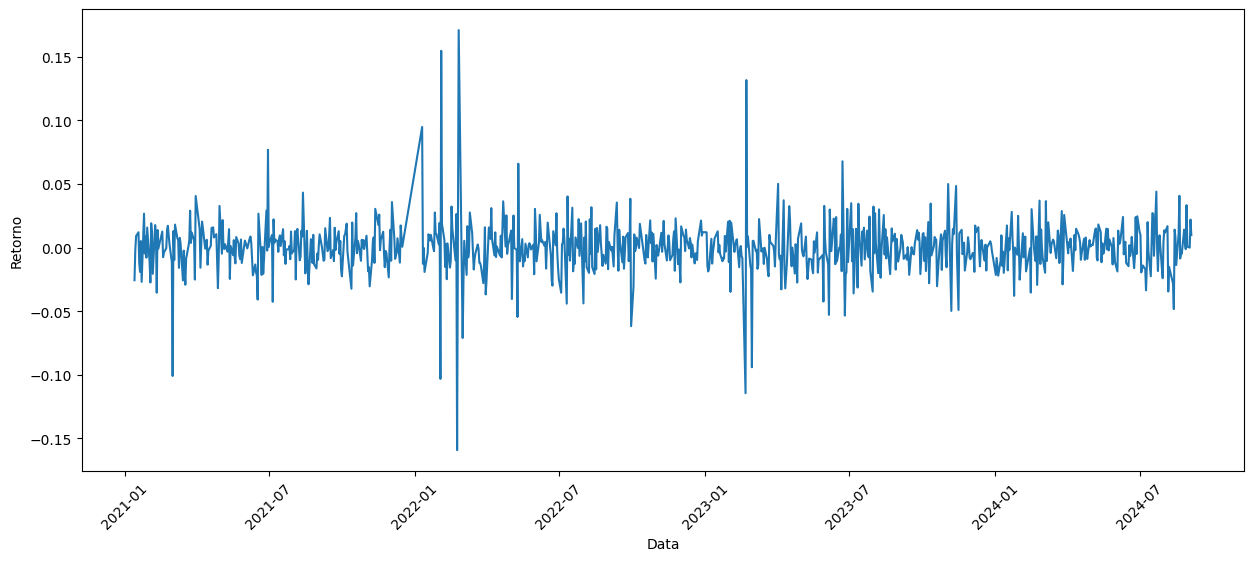

In [11]:
plt.figure(figsize=(15,6))
plt.plot(sorriso['Retornos'])
plt.xlabel('Data')
plt.ylabel('Retorno')
plt.xticks(rotation=45)
plt.show()

## Obtendo as IMFs

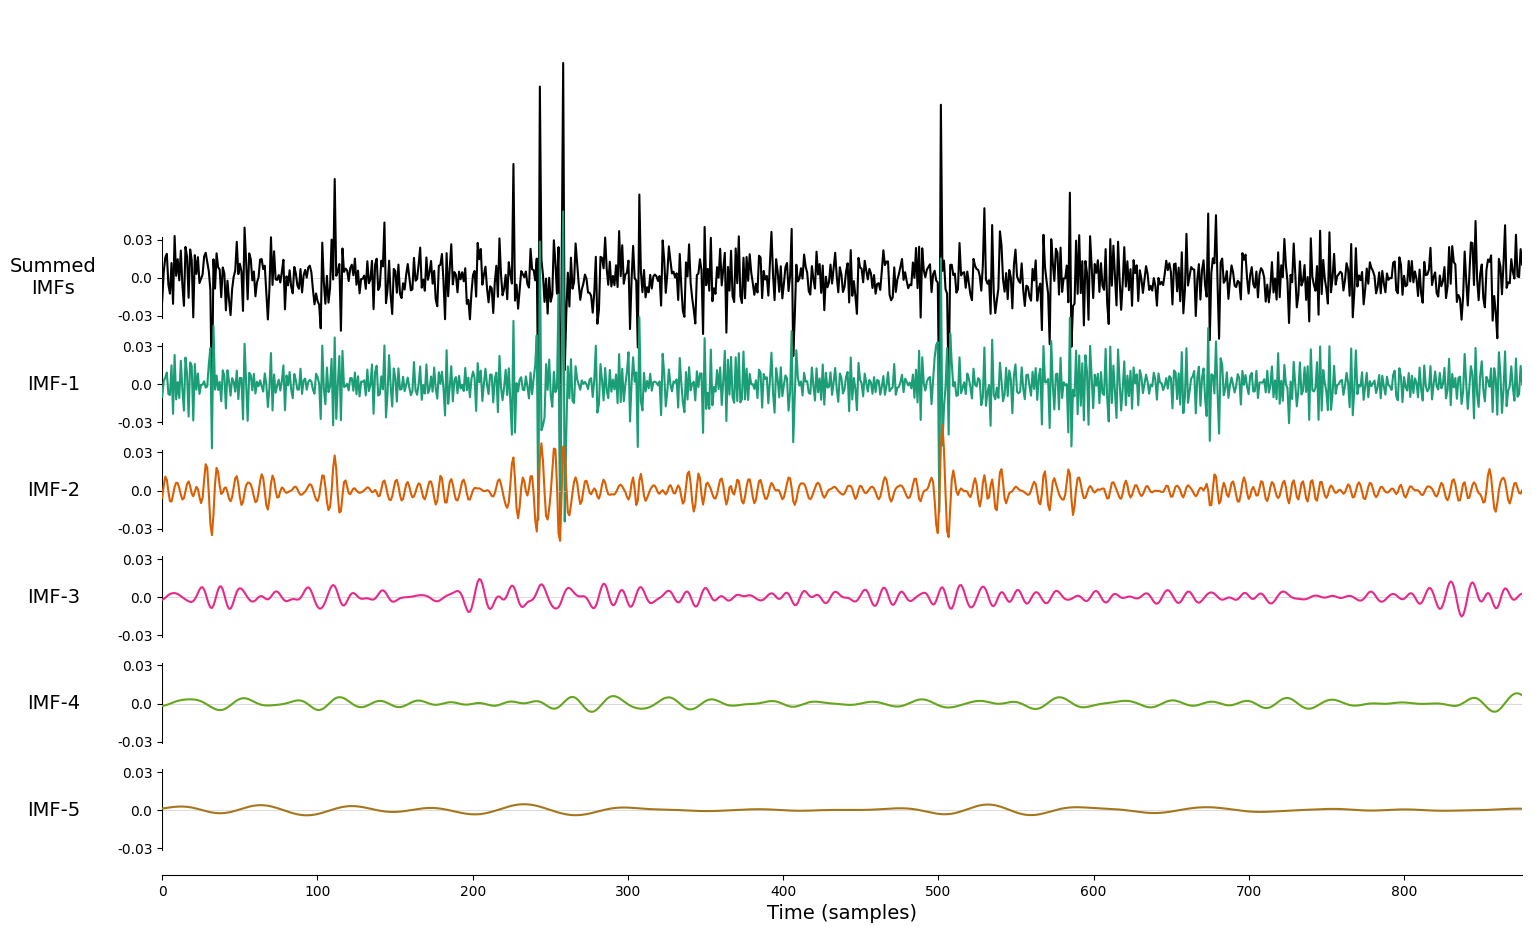

In [19]:
# Rodar uma mask sift

retornos = np.array(sorriso['Retornos'])
imf = emd.sift.mask_sift(retornos, max_imfs=5)

emd.plotting.plot_imfs(imf)
plt.show()

## Análise de frequências

Em seguida, usamos emd.spectra.frequency_transform para calcular o conteúdo de frequência das IMFs. Esta função retorna a fase, frequência e amplitude instantâneas de cada IMF. Ela recebe um conjunto de funções modais intrínsecas (IMFs), a taxa de amostragem e um modo como argumentos de entrada. O modo determina o algoritmo utilizado para calcular a transformada de frequência, havendo várias opções disponíveis, mas, neste caso, utilizamos "nht", que especifica a Transformada de Hilbert Normalizada (Normalised-Hilbert Transform). Esta é uma boa escolha geral, que deve funcionar bem na maioria das circunstâncias.

In [20]:
# Estatísticas da frequência

# IP: Instantaneous Phase (Fase Instantânea). É a fase instantânea do sinal, que pode ser usada para analisar a variação da fase ao longo do tempo.

# IF: Instantaneous Frequency (Frequência Instantânea). Representa a frequência instantânea do sinal, útil para identificar mudanças na frequência ao longo do tempo.

# IA: Instantaneous Amplitude (Amplitude Instantânea). Mede a amplitude instantânea do sinal, permitindo ver como a amplitude varia com o tempo.

IP, IF, IA = emd.spectra.frequency_transform(imf, len(retornos), 'nht')

A Transformada de Hilbert-Huang pode ser considerada como um histograma ponderado pela amplitude dos valores de frequência instantânea de uma IMF. As próximas seções dividem isso em partes.

Para começar, podemos plotar um histograma simples dos valores de frequência instantânea (IF) usando a função hist do matplotlib. Fazemos isso duas vezes: uma como uma contagem padrão e outra ponderando as observações pela sua amplitude.

Irei usar a IMF-2

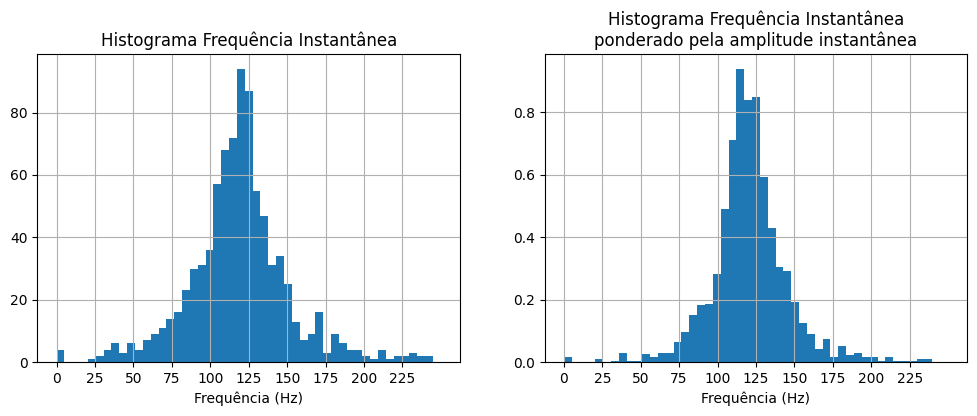

In [30]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
# Plot do histograma simples
plt.hist(IF[:, 1], np.linspace(0, 250))     #[: 1] retorna os valores do índice 1 (IMF-2)
plt.grid(True)
plt.title('Histograma Frequência Instantânea')
plt.xlabel('Frequência (Hz)')
plt.xticks(np.arange(0, 250, 25))

plt.subplot(122)
# Histograma ponderado pela amplitude usando intervalos de frequência
plt.hist(IF[:, 1], np.linspace(0, 250), weights=IA[:, 1])
plt.grid(True)
plt.title('Histograma Frequência Instantânea\nponderado pela amplitude instantânea')
plt.xlabel('Frequência (Hz)')
plt.xticks(np.arange(0, 250, 25))

plt.show()

As duas distribuições são similares, com frequência centrada em 115Hz aproximadamente.
Também parece ter uma cauda um pouco mais arrastada no lado direito, entre 150 e 250Hz
As caudas parecem ser menores no histograma ponderado, sugerindo que esses valores de frequência atípicos tendem a ocorrer em momentos com amplitude muito baixa.

# Transformada Hilbert-Huang com 1 dimensão (Frequência)

OBS: A definição do número de 'bins' do histograma também deve ser levada em conta

In [55]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 250, 200, 'linear')

# Arredondando os valores
print(f'Bin Edges:   {np.round(freq_edges, 3)}')
print(f'Bin Centres: {np.round(freq_centres, 3)}')

Bin Edges:   [  1.      2.245   3.49    4.735   5.98    7.225   8.47    9.715  10.96
  12.205  13.45   14.695  15.94   17.185  18.43   19.675  20.92   22.165
  23.41   24.655  25.9    27.145  28.39   29.635  30.88   32.125  33.37
  34.615  35.86   37.105  38.35   39.595  40.84   42.085  43.33   44.575
  45.82   47.065  48.31   49.555  50.8    52.045  53.29   54.535  55.78
  57.025  58.27   59.515  60.76   62.005  63.25   64.495  65.74   66.985
  68.23   69.475  70.72   71.965  73.21   74.455  75.7    76.945  78.19
  79.435  80.68   81.925  83.17   84.415  85.66   86.905  88.15   89.395
  90.64   91.885  93.13   94.375  95.62   96.865  98.11   99.355 100.6
 101.845 103.09  104.335 105.58  106.825 108.07  109.315 110.56  111.805
 113.05  114.295 115.54  116.785 118.03  119.275 120.52  121.765 123.01
 124.255 125.5   126.745 127.99  129.235 130.48  131.725 132.97  134.215
 135.46  136.705 137.95  139.195 140.44  141.685 142.93  144.175 145.42
 146.665 147.91  149.155 150.4   151.645 152.8

As bordas das faixas de frequência são usadas para calcular as transformadas de Hilbert-Huang. Elas são passadas como o terceiro argumento para emd.spectra.hilberthuang. Os centros das faixas do histograma são retornados junto com a HHT.

In [56]:
f, spectrum = emd.spectra.hilberthuang(IF, IA, freq_edges)

Uma vez que temos nossas faixas de frequência definidas, podemos calcular a transformada de Hilbert-Huang. A HHT mais simples é calculada por emd.spectra.hilberthuang. Esta função retorna um vetor contendo os histogramas ponderados para cada IMF dentro das faixas especificadas pelas bordas.

Aqui, calculamos tanto uma HHT ponderada quanto uma não ponderada.

In [62]:
# HHT ponderada por amplitude para cada IMF
f, spec_weighted = emd.spectra.hilberthuang(IF, IA, freq_edges, sum_imfs=False)

# HHT não ponderada para cada IMF - substituímos os valores de amplitude instantânea por uns
f, spec_unweighted = emd.spectra.hilberthuang(IF, np.ones_like(IA), freq_edges, sum_imfs=False)

Podemos visualizar essas distribuições plotando a HHT em relação às frequências. Note que, embora usemos os freq_edges para definir o histograma, visualizamos isso plotando o valor de cada bin em sua frequência central.

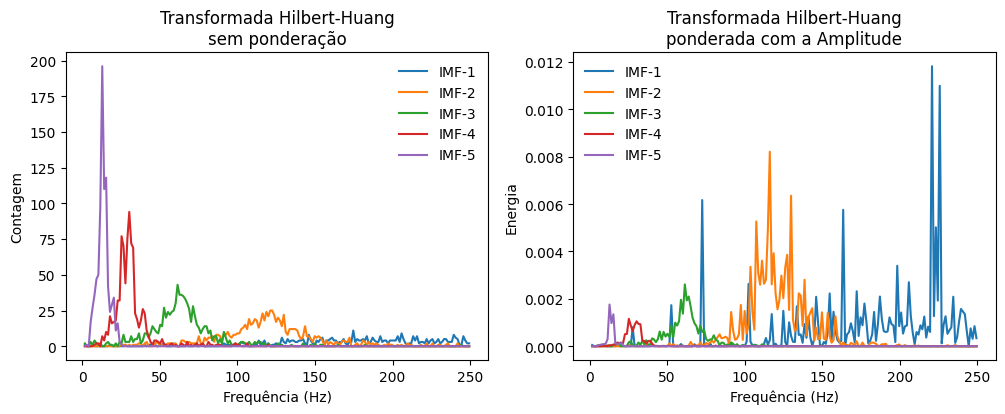

In [63]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(hspace=0.4)
plt.subplot(121)
plt.plot(freq_centres, spec_unweighted)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Contagem')
plt.title('Transformada Hilbert-Huang\nsem ponderação')
plt.legend(['IMF-1', 'IMF-2', 'IMF-3', 'IMF-4', 'IMF-5'], frameon=False)

plt.subplot(122)
plt.plot(freq_centres, spec_weighted)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Energia')
plt.title('Transformada Hilbert-Huang\nponderada com a Amplitude')
plt.legend(['IMF-1', 'IMF-2', 'IMF-3', 'IMF-4', 'IMF-5'], frameon=False)

plt.show()

No primeiro gráfico, nota-se que as últimas IMFs apresentam frequências mais baixas, como esperado.

A IMF-2 apresenta o mesmo comportamento plotado anteriormente.

No segundo gráfico percebe-se que a energia máxima de cada frequência diminui com o passar das IMFs.

Visualmente as frequências que mais aparecem no sinal são entre 120-130Hz (IMF-2) e 220-230Hz (IMF-1).

Nas frequências da IMF-1 também dá para notar picos em torno de 70Hz e 160Hz.

# Transformada Hilbert-Huang com 2 dimensões (Tempo e Frequência)

A Transformada de Hilbert-Huang também pode ser calculada ao longo do tempo para explorar qualquer dinâmica na frequência instantânea. Conceitualmente, isso é muito semelhante à HHT 1D, onde calculamos um histograma ponderado dos valores de frequência instantânea, exceto que agora calculamos um histograma separado para cada ponto no tempo.

Como antes, começamos definindo os bins de frequência. Os bins de tempo são obtidos na taxa de amostragem dos dados. A transformada de frequência 2D é calculada também por meio de emd.spectra.hilberthuang.

In [101]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 250, 100, 'linear')

f, hht = emd.spectra.hilberthuang(IF[:, 1, None], IA[:, 1, None], freq_edges, mode='amplitude', sum_time=False)   #O None atua como um novo eixo, mudando a forma do array. Isso é útil quando você quer fazer operações que requerem arrays 2D em vez de 1D.
time_centres = np.arange(len(retornos) + 1) - 0.5

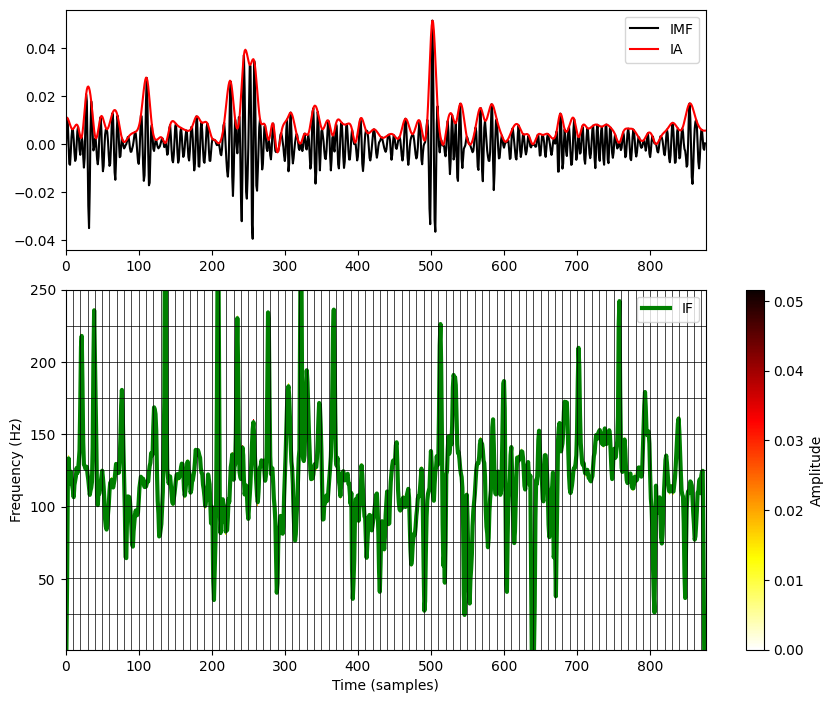

In [102]:
plt.figure(figsize=(10, 8))
# Adicionar a IMF-2 e a amplitude instantânea
plt.axes([.1, .6, .64, .3])
plt.plot(imf[:, 1], 'k')
plt.plot(IA[:, 1], 'r')
plt.legend(['IMF', 'IA'])
plt.xlim(0, len(retornos))

# Adicionar o eixo da IF e legendas
plt.axes([.1, .1, .8, .45])
plt.plot(IF[:, 1], 'g', linewidth=3)
plt.legend(['IF'])

# Plotar a HHT
plt.pcolormesh(time_centres, freq_edges, hht[:, :len(retornos)], cmap='hot_r', vmin=0)

# Setar colorbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

# Adicionar linhas de grid
grid_spacing = 10  # Ajuste este valor para aumentar o espaçamento dos quadrados

for ii in range(0, len(freq_edges), grid_spacing):
    plt.plot((0, len(retornos)), (freq_edges[ii], freq_edges[ii]), 'k', linewidth=0.5)
for ii in range(0, len(retornos), grid_spacing):
    plt.plot((ii, ii), (0, 250), 'k', linewidth=0.5)

# Plotar de novo a frequencia instantânea para visualizar melhor
plt.plot(IF[:, 1], 'g', linewidth=0.05)

# Setar limites e labels
plt.xlim(0, len(retornos))
plt.ylim(1, 250)
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (Hz)')

plt.show()

In [103]:
print(len(freq_edges), len(time_centres))
print(hht.shape)

101 877
(100, 876)
